In [1]:
from netCDF4 import Dataset
import netCDF4 as netcdf
import numpy as np
from matplotlib import pyplot as plt, animation
%matplotlib inline

import matplotlib.ticker as mticker
import matplotlib as mpl
import cmocean as cmo

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.interpolate import griddata

import xarray as xr
import xarray.ufuncs as xu

from datetime import datetime
from matplotlib.path import Path
from matplotlib.patches import Polygon
from matplotlib import rc
font = {'weight':'bold'}
rc('font',**font)

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display
#import geoviews as gv
#import holoviews as hv
#import geoviews.feature as gf
#gv.extension('bokeh', 'matplotlib')

In [2]:
def subset(lonw,lone,latn,lats,data,date1,date2):
    mask_lon = (data.lon >= lonw) & (data.lon <= lone)
    mask_lat = (data.lat >= lats) & (data.lat <= latn)
    %time new_data = data.sel(time=slice(date1,date2)).where(mask_lon & mask_lat, drop=True)
    return new_data

In [3]:
# import HFR dataset
aggr_url = "https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd"
data_h = xr.open_dataset(aggr_url)

# import CMEMS outputs
aggr_url = "./data/CMEMS-global-analysis-forecast-phy-001-024-hourly-u-v.nc"
data_m = xr.open_dataset(aggr_url)

In [4]:
# subset the dataset to the area and time period of interest

lonw, lone = -76.3, -73   # westernmonst and easternmost longitude
lats, latn = 36.5, 39.5 # southernmonst and northernmost latitude
date1 = "2020-05-01"    # initial date
date2 = "2020-06-01"    # final date

# create mask
mask_lon = (data_h.lon >= lonw) & (data_h.lon <= lone)
mask_lat = (data_h.lat >= lats) & (data_h.lat <= latn)

# subset
%time data_sub_h = data_h.sel(time=slice(date1, date2)).where(mask_lon & mask_lat, drop=True)

CPU times: user 550 ms, sys: 260 ms, total: 809 ms
Wall time: 20.9 s


In [5]:
mask_lon = (data_m.longitude >= lonw) & (data_m.longitude <= lone)
mask_lat = (data_m.latitude >= lats) & (data_m.latitude <= latn)
%time data_sub_m = data_m.sel(time=slice(date1, date2)).where(mask_lon & mask_lat, drop=True)

#data.groupby("time.month").mean(dim='time')
#data_sub # 'subseted' dataset

CPU times: user 30 ms, sys: 4.21 ms, total: 34.3 ms
Wall time: 30.9 ms


In [6]:
data_sub_m # 

<xarray.Dataset>
Dimensions:    (time: 744, depth: 1, latitude: 37, longitude: 37)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 36.5 36.58 36.67 36.75 ... 39.33 39.42 39.5
  * time       (time) datetime64[ns] 2020-05-01T00:30:00 ... 2020-05-31T23:30:00
  * longitude  (longitude) float32 -76.0 -75.92 -75.83 ... -73.17 -73.08 -73.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 nan 0.4047 ... -0.047
    uo         (time, depth, latitude, longitude) float32 nan ... -0.04151
Attributes: (12/25)
    title:                              hourly mean fields from Global Ocean ...
    easting:                            longitude
    northing:                           latitude
    history:                            2021/08/05 00:11:43 MERCATOR OCEAN Ne...
    source:                             MERCATOR PSY4QV3R1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              0.494025
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [7]:
# select a specific date and time
date = '2020-05-05T09:00:00'
datah = data_sub_h.sel(time=date,method='nearest')
datam = data_sub_m.sel(time=date,method='nearest') # mimics the model output - to be merged with Teresa and Maurício's code
# need to import the satellite data s well

In [8]:
datah, datam = data_sub_h, data_sub_m

In [9]:
# calculate the magnitude of surface currents
Magh = np.sqrt(datah.u**2+datah.v**2)
Magm = np.sqrt(datam.uo**2+datam.vo**2)

# create the mesh
xh, yh = np.meshgrid(datah.lon.values,datah.lat.values)
xm, ym = np.meshgrid(datam.longitude.values,datam.latitude.values)

# mask data
Magh = np.ma.masked_invalid(Magh)
Magm = np.ma.masked_invalid(Magm).squeeze()
Uh = np.ma.masked_invalid(datah.u.values)
Vh = np.ma.masked_invalid(datah.v.values)
Um = np.ma.masked_invalid(datam.uo.values).squeeze()
Vm = np.ma.masked_invalid(datam.vo.values).squeeze()

In [22]:
#Angleh = np.pi/2 - np.arctan2(Uh/Magh, Vh/Magh)
#Anglem = np.pi/2 - np.arctan2(Um/magm, Vm/Magm)

In [71]:
def make_map(lonw,lone,lats,latn,ax,flag=0):
    ax.set_extent([lonw, lone, lats, latn])

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    stp = 1
    lon_ticks = np.around(np.arange(int(lonw),int(lone)+stp),1) #[-75, -74, -73, -72, -71, -70, -69]
    lat_ticks = np.around(np.arange(lats,latn+stp),1)

    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    ax.xaxis.set_tick_params(which='major', size=2., width=1, 
                             direction='in', top='on', pad=7)
    ax.yaxis.set_tick_params(which='major', size=2., width=1, 
                             direction='in', right='on',pad=7)
    
    if flag == 0: ax.tick_params(labelleft=True,labelbottom=False,labeltop=True,labelright=False)  
    elif flag == 1: ax.tick_params(labelleft=False,labelbottom=False,labeltop=True,labelright=False)  
    else: ax.tick_params(labelleft=False,labelbottom=False,labeltop=True,labelright=True)  

    ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='0', alpha=0.4)
    ax.coastlines(resolution='10m',linewidth=0.3)
    return ax

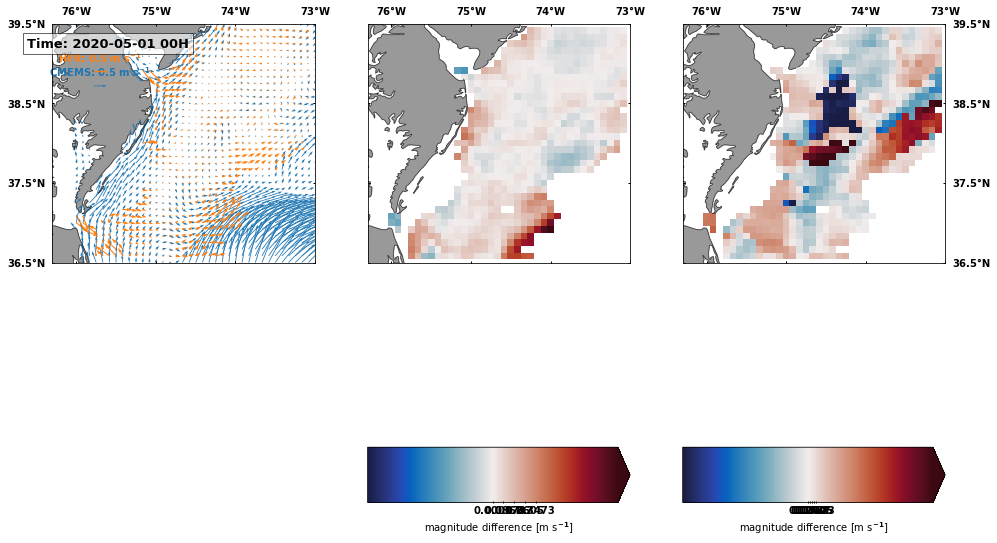

In [79]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(10,3)
i = 0
proj = ccrs.PlateCarree()
#ax = fig.add_subplot(1,3,1,projection=proj)
fig = plt.figure(1,figsize=(16,12))
ax1 = fig.add_subplot(gs[:9,0],projection=proj)
ax2 = fig.add_subplot(gs[:9,1],projection=proj)
ax3 = fig.add_subplot(gs[:9,2],projection=proj)
ax4 = fig.add_subplot(gs[9,1])
ax5 = fig.add_subplot(gs[9,2])
ax1 = make_map(lonw,lone,lats,latn,ax1,flag=0)

uh = griddata((xh.ravel(),yh.ravel()),Uh[i].ravel(),(xm,ym))
vh = griddata((xh.ravel(),yh.ravel()),Vh[i].ravel(),(xm,ym))
magh = griddata((xh.ravel(),yh.ravel()),Magh[i].ravel(),(xm,ym))

um, vm, magm = Um[i], Vm[i], Magm[i]
angleh = np.pi/2 - np.arctan2(uh/magh, vh/magh)
anglem = np.pi/2 - np.arctan2(um/magm, vm/magm)

# plot current vectors
c1, c2 = 'C1', 'C0'
cf1=ax1.quiver(xm,ym,uh,vh,color=c1,#magh,cmap=cmo.cm.tempo,
             scale=10,width=.004,zorder=2)
cf2=ax1.quiver(xm,ym,um,vm,color=c2,#magm,cmap=cmo.cm.amp,
             scale=10,width=.003,zorder=1)

# add the scale for the currents magnitude
qk = ax1.quiverkey(cf1, -75.7, 38.9, 0.5, label='HFR: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='data', labelcolor=c1)
qk = ax1.quiverkey(cf2, -75.7, 38.72, 0.5, label='CMEMS: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='data', labelcolor=c2)

# time stamp
the_time = np.datetime_as_string(datah.time.values[i], unit='h')#'%Y-%m-%d')
the_time = the_time[:10]+' %sH'%the_time[11:]
ax1.text(-75.6,39.25,'Time: {:}'.format(the_time),fontsize=13,va='center', ha='center',
        bbox=dict(facecolor='w', alpha=.6),transform=proj)


#ax = fig.add_subplot(1,3,2,projection=proj)
ax2 = make_map(lonw,lone,lats,latn,ax2,flag=1)
cf = ax2.pcolormesh(xm,ym,magm-magh,vmin=-1,vmax=1,cmap=cmo.cm.balance)
#cax,kw = mpl.colorbar.make_axes(ax2,location='bottom',pad=0.05,aspect=5)
out=fig.colorbar(cf,cax=ax4,ticks=bounds,extend='max',**kw)
out.set_label('magnitude difference [m s$^{-1}$]',size=10)
out.ax.tick_params(direction='in',size=2., width=1)

#ax = fig.add_subplot(1,3,3,projection=proj)
ax3 = make_map(lonw,lone,lats,latn,ax3,flag=2)
cf = ax3.pcolormesh(xm,ym,anglem-angleh,vmin=-5,vmax=5,cmap=cmo.cm.balance)
out=fig.colorbar(cf,cax=ax5,ticks=bounds,extend='max',**kw)
out.set_label('magnitude difference [m s$^{-1}$]',size=10)
out.ax.tick_params(direction='in',size=2., width=1)
#out.ax.tick_params(direction='in',size=2., width=1)
#print(i)
plt.show()
plt.close()


In [64]:
np.nanmin(magm-magh)

-0.44040848854851555

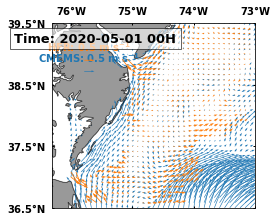

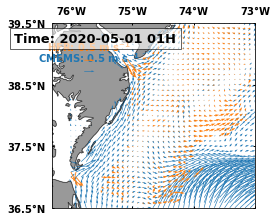

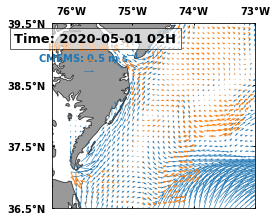

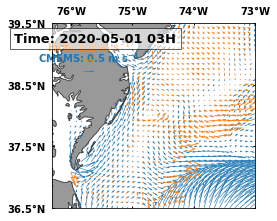

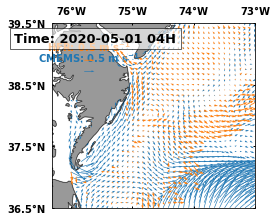

In [46]:
# conventional map (cartopy)
proj = ccrs.PlateCarree()

#for i in range(5):
i = 0
fig = plt.figure(1,figsize=(8,12))
ax = fig.add_subplot(1,2,1,projection=proj)
ax.set_extent([lonw, lone, lats, latn])

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

stp = 1
lon_ticks = np.around(np.arange(int(lonw),int(lone)+stp),1) #[-75, -74, -73, -72, -71, -70, -69]
lat_ticks = np.around(np.arange(lats,latn+stp),1)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, 
                         direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, 
                         direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=False,labeltop=True,labelright=False)  
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='0', alpha=0.4)
ax.coastlines(resolution='10m',linewidth=0.3)

#vmax = np.nanmean(magh)+2*np.nanstd(magh)
#bounds = np.linspace(0,vmax,5)
#norm = mpl.colors.Normalize(vmin=0., vmax=vmax)

uh = griddata((xh.ravel(),yh.ravel()),Uh[i].ravel(),(xm,ym))
vh = griddata((xh.ravel(),yh.ravel()),Vh[i].ravel(),(xm,ym))
magh = griddata((xh.ravel(),yh.ravel()),Magh[i].ravel(),(xm,ym))

um, vm, magm = Um[i], Vm[i], Magm[i]

# plot current vectors
c1, c2 = 'C1', 'C0'
cf1=ax.quiver(xm,ym,uh,vh,color=c1,#magh,cmap=cmo.cm.tempo,
             scale=10,width=.004,zorder=2)
cf2=ax.quiver(xm,ym,um,vm,color=c2,#magm,cmap=cmo.cm.amp,
             scale=10,width=.003,zorder=1)

# add the scale for the currents magnitude
qk = ax.quiverkey(cf1, -75.7, 38.9, 0.5, label='HFR: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='data', labelcolor=c1)
qk = ax.quiverkey(cf2, -75.7, 38.72, 0.5, label='CMEMS: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='data', labelcolor=c2)

# time stamp
the_time = np.datetime_as_string(datah.time.values[i], unit='h')#'%Y-%m-%d')
the_time = the_time[:10]+' %sH'%the_time[11:]
ax.text(-75.6,39.25,'Time: {:}'.format(the_time),fontsize=13,va='center', ha='center',
        bbox=dict(facecolor='w', alpha=.6),transform=proj)

#print(i)
plt.show()
plt.close()



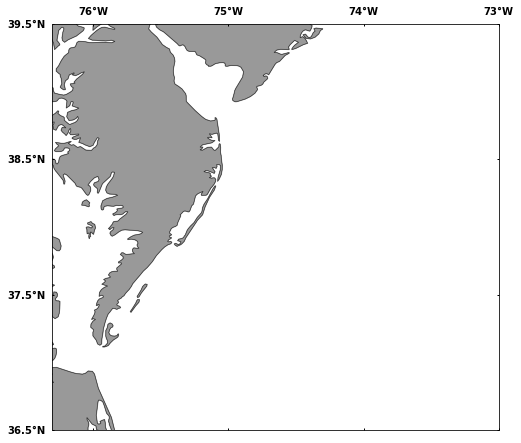

In [15]:
# Create map
proj = ccrs.PlateCarree()                     # map projection
fig = plt.figure(1, figsize=(8,12))           # create figure object
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([lonw, lone, lats, latn])

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

stp = 1
lon_ticks = np.around(np.arange(int(lonw),int(lone)+1),stp) #[-75, -74, -73, -72, -71, -70, -69]
lat_ticks = np.around(np.arange(lats,latn+1),stp)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, 
                         direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, 
                         direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=False,labeltop=True,labelright=False)  
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='k', alpha=0.4)
ax.coastlines(resolution='10m',linewidth=0.3)

#vmax = np.nanmean(magh)+2*np.nanstd(magh)
#bounds = np.linspace(0,vmax,5)
#norm = mpl.colors.Normalize(vmin=0., vmax=vmax)

def plot_map(i):
    uh = griddata((xh.ravel(),yh.ravel()),Uh[i].ravel(),(xm,ym))
    vh = griddata((xh.ravel(),yh.ravel()),Vh[i].ravel(),(xm,ym))
    magh = griddata((xh.ravel(),yh.ravel()),Magh[i].ravel(),(xm,ym))
    
    um, vm, magm = Um[i], Vm[i], Magm[i]

    # plot current vectors
    c1, c2 = 'C1', 'C0'
    cf1=ax.quiver(xm,ym,uh,vh,color=c1,#magh,cmap=cmo.cm.tempo,
                 scale=10,width=.004,zorder=2)
    cf2=ax.quiver(xm,ym,um,vm,color=c2,#magm,cmap=cmo.cm.amp,
                 scale=10,width=.003,zorder=1)

    # add the scale for the currents magnitude
    qk = ax.quiverkey(cf1, 0.25, 0.65, 0.5, label='HFR: 0.5 m s$^{-1}$', labelpos='N',
                       coordinates='figure', labelcolor=c1)
    qk = ax.quiverkey(cf2, 0.25, 0.62, 0.5, label='CMEMS: 0.5 m s$^{-1}$', labelpos='N',
                       coordinates='figure', labelcolor=c2)

    # time stamp
    the_time = np.datetime_as_string(datah.time.values[i], unit='h')#'%Y-%m-%d')
    the_time = the_time[:10]+' %sH'%the_time[11:]
    ax.text(-75.6,39.25,'Time: {:}'.format(the_time),fontsize=13,va='center', ha='center',
                 bbox=dict(facecolor='w', alpha=.6),
             transform=proj)
    plt.show()
    #plt.close()
    
ani = animation.FuncAnimation(
    plt.gcf(),             # figure
    plot_map,         # name of the function above
    frames=range(Vm.shape[0]),       # Could also be iterable or list
    interval=200,     # ms between frames
    blit=False
)

In [ ]:
ani

In [16]:
HTML(ani.to_jshtml())

Animation size has reached 21138697 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

In [ ]:
proj = ccrs.PlateCarree()

stph, stpm = 2, 2 #subsample the vectorfield

# compute angles of the vector
angleh = np.pi/2 - np.arctan2(uh/magh, vh/magh)
anglem = np.pi/2 - np.arctan2(um/magm, vm/magm)

# holoviews objects
#hfr = gv.VectorField((xm[::stph,::stph], ym[::stph,::stph],           # HFR vectorfield
#                      angleh[::stph,::stph], magh[::stph,::stph]), 
#                     crs=proj)
#mdl = gv.VectorField((xm[::stpm,::stpm], ym[::stpm,::stpm],           # 'model' vectorfield
#                    anglem[::stpm,::stpm], magm[::stpm,::stpm]), 
#                     crs=proj)

In [ ]:
#tiles = gv.tile_sources.CartoLight                # map object - I really didn't like any of them

# plot interactive map
#hfr.opts(magnitude='Magnitude',color='red',     
#         padding=.1, colorbar=True, line_width=2,
#         height=350, width=350) * \
#mdl.opts(magnitude='Magnitude',color='black',
#         padding=.1, colorbar=True, line_width=2,
#         height=350, width=350) * tiles.opts(alpha=1,fontsize='0pt')
# not sure which colors to choose.... bur colormaps for each dataset does not look good
#arquivo track satélite 228!!

In [ ]:
#hv.help(hv.Tiles)

In [ ]:
# time holograph test
#kdims = ['time', 'lon', 'lat']
#vdims = ['u','v']
#data_gv = gv.Dataset(data_sub, kdims=kdims, vdims=vdims)
#hv.Dimension.type_formatters[np.datetime64] = '%Y-%m-%d'